<a href="https://colab.research.google.com/github/Sathwick-Reddy-M/550-Research-Paper/blob/main/Research_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspellchecker langdetect

In [2]:
from wordcloud import WordCloud
import numpy as np
import pandas as pd
import re
import nltk

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
%cd "/content/drive/MyDrive/550/Research Paper/fnc-1/"

/content/drive/MyDrive/550/Research Paper/fnc-1


# Dataset Analysis

## Intial Data Insights

In [4]:
# Load the data

train_bodies = pd.read_csv('train_bodies.csv')
train_stances = pd.read_csv('train_stances.csv')

In [5]:
train_bodies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1683 entries, 0 to 1682
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Body ID      1683 non-null   int64 
 1   articleBody  1683 non-null   object
dtypes: int64(1), object(1)
memory usage: 26.4+ KB


In [6]:
train_stances.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49972 entries, 0 to 49971
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  49972 non-null  object
 1   Body ID   49972 non-null  int64 
 2   Stance    49972 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [7]:
# Find duplicated articleBody entries
duplicate_article_bodies = train_bodies[train_bodies.duplicated(subset=['articleBody'], keep=False)]

# Extract duplicated articleBodies and their corresponding Body IDs
duplicated_data = train_bodies[train_bodies['articleBody'].isin(duplicate_article_bodies['articleBody'])]

print(len(duplicated_data.sort_values(by='articleBody')))
# Display duplicated articleBodies and their corresponding Body IDs
duplicated_data.sort_values(by='articleBody')

28


,Body ID,articleBody
1292,1946,A Texas National Guard soldier scans the Mexic...
499,742,A Texas National Guard soldier scans the Mexic...
182,286,A rumor on Tuesday claims Apple's upcoming App...
971,1458,A rumor on Tuesday claims Apple's upcoming App...
1461,2201,Along with unveiling the Apple Watch earlier t...
1610,2419,Along with unveiling the Apple Watch earlier t...
28,41,Although Apple has given us our first peek at ...
1654,2485,Although Apple has given us our first peek at ...
854,1291,Apple is shifting its retail strategy for the ...
1366,2056,Apple is shifting its retail strategy for the ...


In [8]:
print(len(train_stances[train_stances['Body ID'].isin([1946, 742])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([286, 1458])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([2201, 2419])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([41, 2485])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([1291, 2056])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([2277, 300])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([105, 373])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([2271, 577])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([562, 2092])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([490, 1826])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([877, 2223])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([790, 645])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([2188, 2365])]), end=", ")
print(len(train_stances[train_stances['Body ID'].isin([181, 1983])]))

62, 79, 45, 9, 83, 34, 86, 9, 49, 81, 37, 10, 46, 52


In [9]:
sum([62, 79, 45, 9, 83, 34, 86, 9, 49, 81, 37, 10, 46, 52])

682

In [10]:
682-14, 49972-668

(668, 49304)

## Cleaning

In [11]:
# Identify duplicated bodies
duplicate_bodies = train_bodies[train_bodies.duplicated(subset=['articleBody'], keep=False)]

# Group duplicated bodies by articleBody and assign unique IDs
unique_ids = {}
unique_id_counter = 10000
for _, group in duplicate_bodies.groupby('articleBody'):
    if group['articleBody'].iloc[0] not in unique_ids:
        unique_ids[group['articleBody'].iloc[0]] = unique_id_counter
        unique_id_counter += 1

# Assign unique IDs to the duplicated bodies
duplicate_bodies['unique_body_id'] = duplicate_bodies['articleBody'].map(unique_ids)

# Update the Body ID column in both datasets with the new unique IDs
for idx, row in duplicate_bodies.iterrows():
    train_bodies.loc[train_bodies['articleBody'] == row['articleBody'], 'Body ID'] = row['unique_body_id']
    train_stances.loc[train_stances['Body ID'] == row['Body ID'], 'Body ID'] = row['unique_body_id']

# Drop duplicate rows from both datasets
train_bodies_cleaned = train_bodies.drop_duplicates()
train_stances_cleaned = train_stances.drop_duplicates()

<ipython-input-11-b959a34085cf>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  duplicate_bodies['unique_body_id'] = duplicate_bodies['articleBody'].map(unique_ids)


In [12]:
duplicate_bodies.sort_values(by='articleBody')

,Body ID,articleBody,unique_body_id
1292,1946,A Texas National Guard soldier scans the Mexic...,10000
499,742,A Texas National Guard soldier scans the Mexic...,10000
182,286,A rumor on Tuesday claims Apple's upcoming App...,10001
971,1458,A rumor on Tuesday claims Apple's upcoming App...,10001
1461,2201,Along with unveiling the Apple Watch earlier t...,10002
1610,2419,Along with unveiling the Apple Watch earlier t...,10002
28,41,Although Apple has given us our first peek at ...,10003
1654,2485,Although Apple has given us our first peek at ...,10003
854,1291,Apple is shifting its retail strategy for the ...,10004
1366,2056,Apple is shifting its retail strategy for the ...,10004


## Row Counts and Values

In [13]:
train_bodies_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1669 entries, 0 to 1682
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Body ID      1669 non-null   int64 
 1   articleBody  1669 non-null   object
dtypes: int64(1), object(1)
memory usage: 39.1+ KB


In [14]:
train_bodies_cleaned.isnull().sum()

Body ID        0
articleBody    0
dtype: int64

In [15]:
train_bodies_cleaned.nunique()

Body ID        1669
articleBody    1669
dtype: int64

In [16]:
train_stances_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49538 entries, 0 to 49971
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Headline  49538 non-null  object
 1   Body ID   49538 non-null  int64 
 2   Stance    49538 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


In [17]:
train_stances_cleaned.isnull().sum()

Headline    0
Body ID     0
Stance      0
dtype: int64

In [18]:
train_stances_cleaned.nunique()

Headline    1648
Body ID     1669
Stance         4
dtype: int64

In [37]:
merged_data = pd.merge(train_stances_cleaned, train_bodies_cleaned, on='Body ID')

In [39]:
from langdetect import detect
from collections import defaultdict

# Create a dictionary to store language detection results for each unique body and headline text
body_language_cache = defaultdict(lambda: None)
headline_language_cache = defaultdict(lambda: None)

def is_english_with_cache(text, cache):
    if cache[text] is not None:
        return cache[text]
    try:
        lang = detect(text)
        cache[text] = lang == 'en'
        return lang == 'en'
    except:
        return False

# Add a column to indicate if body content is in English
merged_data['body_is_english_cached'] = merged_data.apply(lambda row: is_english_with_cache(row['articleBody'], body_language_cache), axis=1)

# Add a column to indicate if headline content is in English
merged_data['headline_is_english_cached'] = merged_data.apply(lambda row: is_english_with_cache(row['Headline'], headline_language_cache), axis=1)

# Filter out rows where both body and headline content are not in English
merged_data_cleaned = merged_data[(merged_data['body_is_english_cached']) & (merged_data['headline_is_english_cached'])]

# Drop the language cache columns
merged_data_cleaned.drop(['body_is_english_cached', 'headline_is_english_cached'], axis=1, inplace=True)

<ipython-input-39-1ea7078c38ac>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_cleaned.drop(['body_is_english_cached', 'headline_is_english_cached'], axis=1, inplace=True)


In [40]:
merged_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 46750 entries, 0 to 49537
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Headline     46750 non-null  object
 1   Body ID      46750 non-null  int64 
 2   Stance       46750 non-null  object
 3   articleBody  46750 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.8+ MB


In [43]:
merged_data_cleaned.isnull().sum()

Headline       0
Body ID        0
Stance         0
articleBody    0
dtype: int64

In [44]:
merged_data_cleaned.nunique()

Headline       1554
Body ID        1659
Stance            4
articleBody    1659
dtype: int64

In [45]:
# Find the number of distinct Headline and BodyID
num_distinct_headlines = merged_data_cleaned['Headline'].nunique()
num_distinct_body_ids = merged_data_cleaned['Body ID'].nunique()

# Print the results
print("Number of distinct Headlines:", num_distinct_headlines)
print("Number of distinct Body IDs:", num_distinct_body_ids)

Number of distinct Headlines: 1554
Number of distinct Body IDs: 1659


In [46]:
# Calculate the distribution of stance classes
stance_counts = merged_data_cleaned['Stance'].value_counts()
stance_distribution = stance_counts / stance_counts.sum()

# Combine original counts and normalized counts into a DataFrame
distribution_df = pd.concat([stance_counts, stance_distribution], axis=1)
distribution_df.columns = ['Original Counts', 'Normalized Counts']

# Print the distribution
print("Stance Distribution:")
print(distribution_df)

Stance Distribution:
           Original Counts  Normalized Counts
Stance                                       
unrelated            34277           0.733198
discuss               8332           0.178225
agree                 3374           0.072171
disagree               767           0.016406


In [47]:
# Define a regex pattern to match any character that is not a letter or whitespace
pattern = r'[^a-zA-Z\s]'

# Filter the dataframe to get distinct headlines that match the pattern
distinct_headlines_with_numbers_or_special_chars = merged_data[merged_data['Headline'].str.contains(pattern)]['Headline'].unique()

# Print the distinct headlines
print("Distinct Headlines containing numbers or special characters:", len(distinct_headlines_with_numbers_or_special_chars))
print(distinct_headlines_with_numbers_or_special_chars)

Distinct Headlines containing numbers or special characters: 1300
["Police find mass graves with at least '15 bodies' near Mexico town where 43 students disappeared after police clash"
 'Seth Rogen to Play Apple’s Steve Wozniak'
 'Mexico police find mass grave near site 43 students vanished' ...
 'Apple is limiting features on the Apple Watch to save battery life, according to developers'
 'Mom Calls 911 On Masturbating Teenage Son; Boy Arrested, Charged With New ‘Self-Rape’ State Law'
 "Sushi lover's entire body left riddled with WORMS after eating contaminated sashimi"]


In [48]:
# Define a regex pattern to match any character that is not a letter or whitespace
pattern = r'[^a-zA-Z\s]'

# Filter the dataframe to get distinct bodies that match the pattern
distinct_bodies_with_numbers_or_special_chars = merged_data[merged_data['articleBody'].str.contains(pattern)]['articleBody'].unique()

# Print the distinct bodies
print("Distinct Bodies containing numbers or special characters:", len(distinct_bodies_with_numbers_or_special_chars))
print(distinct_bodies_with_numbers_or_special_chars)

Distinct Bodies containing numbers or special characters: 1666
['Danny Boyle is directing the untitled film\r\n\r\nSeth Rogen is being eyed to play Apple co-founder Steve Wozniak in Sony’s Steve Jobs biopic.\r\n\r\nDanny Boyle is directing the untitled film, based on Walter Isaacson\'s book and adapted by Aaron Sorkin, which is one of the most anticipated biopics in recent years.\r\n\r\nNegotiations have not yet begun, and it’s not even clear if Rogen has an official offer, but the producers — Scott Rudin, Guymon Casady and Mark Gordon — have set their sights on the talent and are in talks.\r\n\r\nOf course, this may all be for naught as Christian Bale, the actor who is to play Jobs, is still in the midst of closing his deal. Sources say that dealmaking process is in a sensitive stage.\r\n\r\nInsiders say Boyle will is flying to Los Angeles to meet with actress to play one of the female leads, an assistant to Jobs. Insiders say that Jessica Chastain is one of the actresses on the meeti

It's better not remove the digits because they hold the meaning some of the headlines. But we can just ignore the special characters anyway because they don't help much in the identification of the relation between the headline and body

## Analysing the Merged Data

In [49]:
merged_data.head()

,Headline,Body ID,Stance,articleBody,body_is_english_cached,headline_is_english_cached
0,Police find mass graves with at least '15 bodi...,712,unrelated,Danny Boyle is directing the untitled film\r\n...,True,True
1,Seth Rogen to Play Apple’s Steve Wozniak,712,discuss,Danny Boyle is directing the untitled film\r\n...,True,True
2,Mexico police find mass grave near site 43 stu...,712,unrelated,Danny Boyle is directing the untitled film\r\n...,True,True
3,Mexico Says Missing Students Not Found In Firs...,712,unrelated,Danny Boyle is directing the untitled film\r\n...,True,True
4,New iOS 8 bug can delete all of your iCloud do...,712,unrelated,Danny Boyle is directing the untitled film\r\n...,True,True


### Body ID


Body IDs with the Highest Number of Associated Articles:
Body ID: 1948, Number of Articles: 164

Body IDs with the Lowest Number of Associated Articles:
Body ID: 83, Number of Articles: 1
Body ID: 1542, Number of Articles: 1
Body ID: 282, Number of Articles: 1
Body ID: 228, Number of Articles: 1
Body ID: 372, Number of Articles: 1
Body ID: 982, Number of Articles: 1
Body ID: 397, Number of Articles: 1
Body ID: 232, Number of Articles: 1
Body ID: 2013, Number of Articles: 1
Body ID: 136, Number of Articles: 1
Body ID: 112, Number of Articles: 1
Body ID: 151, Number of Articles: 1
Body ID: 323, Number of Articles: 1
Body ID: 515, Number of Articles: 1
Body ID: 200, Number of Articles: 1
Body ID: 243, Number of Articles: 1
Body ID: 407, Number of Articles: 1
Body ID: 915, Number of Articles: 1
Body ID: 362, Number of Articles: 1
Body ID: 464, Number of Articles: 1
Body ID: 553, Number of Articles: 1
Body ID: 175, Number of Articles: 1
Body ID: 135, Number of Articles: 1
Body ID: 74, Numb

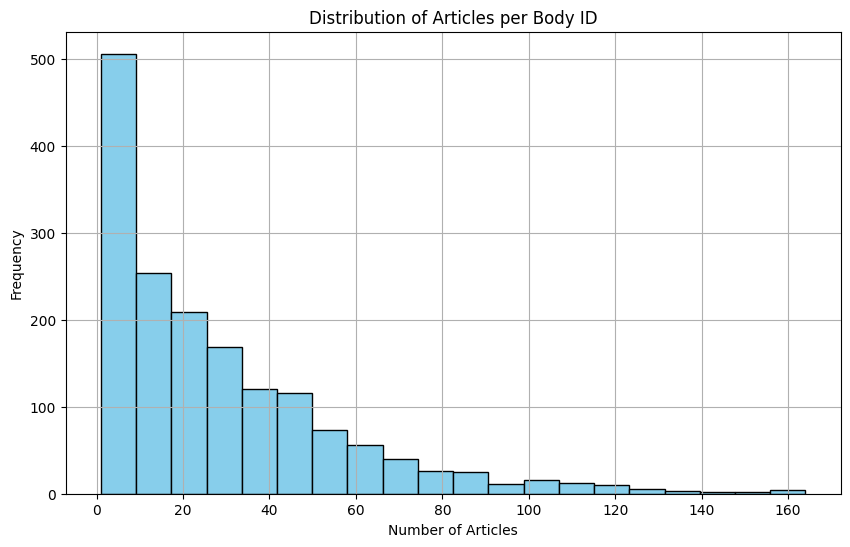

In [50]:
import matplotlib.pyplot as plt

# Calculate the number of articles associated with each Body ID
articles_per_body_id = merged_data_cleaned['Body ID'].value_counts()

# Find the maximum and minimum number of articles
max_articles_count = articles_per_body_id.max()
min_articles_count = articles_per_body_id.min()

# Find Body IDs with the maximum and minimum number of articles
max_articles_body_ids = articles_per_body_id[articles_per_body_id == max_articles_count]
min_articles_body_ids = articles_per_body_id[articles_per_body_id == min_articles_count]

# Print Body IDs with the maximum number of articles
print("\nBody IDs with the Highest Number of Associated Articles:")
for body_id, count in max_articles_body_ids.items():
    print(f"Body ID: {body_id}, Number of Articles: {count}")

# Print Body IDs with the minimum number of articles
print("\nBody IDs with the Lowest Number of Associated Articles:")
for body_id, count in min_articles_body_ids.items():
    print(f"Body ID: {body_id}, Number of Articles: {count}")


# Plot the Distribution of the Number of Articles per Body ID
plt.figure(figsize=(10, 6))
articles_per_body_id.plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Articles')
plt.ylabel('Frequency')
plt.title('Distribution of Articles per Body ID')
plt.grid(True)
plt.show()


Frequency Distribution: The histogram values show that there are 515 body IDs associated with approximately 1-10 articles, making this the most common range. As the number of articles per body increases, the frequency decreases.

Variability in Article Counts: There is significant variability in the number of articles associated with each body, as indicated by the spread of values across the histogram bins.

Long Tail: The histogram has a right-skewed distribution, with fewer body IDs having a large number of associated articles. This suggests that while some bodies have a high number of associated articles, most bodies have relatively few.

Sparse Distribution: Towards the right end of the histogram, there are bins with very few or no body IDs. This indicates that only a few bodies have a very high number of associated articles, and such cases are relatively rare.

Bin Range Interpretation: Each bin in the histogram represents a range of article counts associated with body IDs. For example, the bin from 1 to approximately 10.15 represents body IDs associated with 1-10 articles.

In [52]:
merged_data_cleaned['Body ID'].value_counts()

Body ID
1948    164
1921    163
524     161
1549    156
40      150
       ... 
6         1
376       1
156       1
1523      1
1066      1
Name: count, Length: 1659, dtype: int64

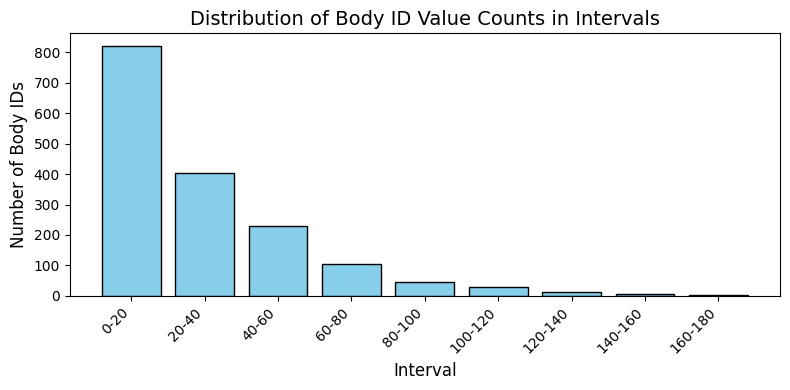

In [53]:
# X-Axis - Range for Value Counts Y-Axis - Number of Body_ids (count) fall in that range

import matplotlib.pyplot as plt

# Define intervals for value counts
interval_size = 20
max_count = merged_data_cleaned['Body ID'].value_counts().max()
num_intervals = max_count // interval_size + 1
intervals = [(i * interval_size, (i + 1) * interval_size) for i in range(num_intervals)]

# Count how many Body IDs fall into each interval
body_id_counts = merged_data_cleaned['Body ID'].value_counts()
counts_in_intervals = [((body_id_counts >= interval[0]) & (body_id_counts < interval[1])).sum() for interval in intervals]

# Plot the distribution of Body ID counts in intervals
plt.figure(figsize=(8, 4))  # Set smaller figure size here
plt.bar(range(num_intervals), counts_in_intervals, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Interval', fontsize=12)
plt.ylabel('Number of Body IDs', fontsize=12)
plt.title('Distribution of Body ID Value Counts in Intervals', fontsize=14)
plt.xticks(range(num_intervals), [f'{interval[0]}-{interval[1]}' for interval in intervals], rotation=45, ha='right')

# Show plot
plt.tight_layout()
plt.show()


In [54]:
counts_in_intervals

[821, 405, 229, 106, 47, 30, 13, 5, 3]

### Stance

In [55]:
merged_data_cleaned.groupby('Stance').size()

Stance
agree         3374
disagree       767
discuss       8332
unrelated    34277
dtype: int64

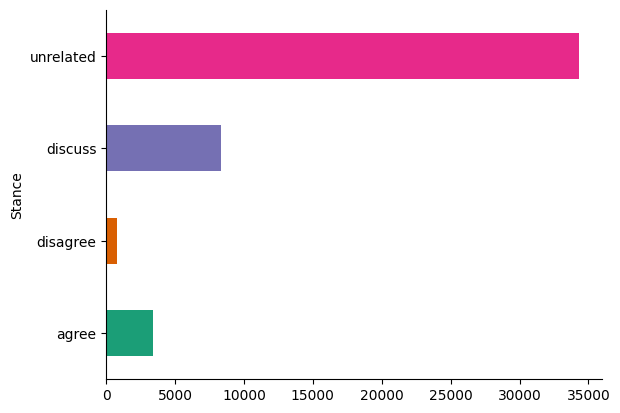

In [56]:
from matplotlib import pyplot as plt
import seaborn as sns
merged_data_cleaned.groupby('Stance').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

The dataset contains stance annotations categorized into four types: 'agree', 'disagree', 'discuss', and 'unrelated'. Among these, 'unrelated' stances comprise the majority with 34,277 instances, representing approximately 69.2% of the total. 'Discuss' stances follow with 8,332 instances, accounting for around 16.8% of the dataset. 'Agree' and 'disagree' stances have relatively fewer occurrences, with 3,374 and 767 instances respectively, making up about 6.8% and 1.5% of the dataset respectively.

### Word Count Analysis

For unique Article Bodies and unique Article Headlines

Word Count Distribution for Headlines:
count    1554.000000
mean       12.832046
std         4.742647
min         2.000000
25%        10.000000
50%        12.000000
75%        15.000000
max        45.000000
dtype: float64

Word Count Distribution for Article Bodies:
count    1659.000000
mean      426.338156
std       345.511772
min         9.000000
25%       225.000000
50%       350.000000
75%       525.500000
max      5358.000000
dtype: float64

Summary Statistics for Headline Word Counts:
Mean: 12.832046332046332
Median: 12.0
Minimum: 2
Maximum: 45

Summary Statistics for Article Body Word Counts:
Mean: 426.3381555153707
Median: 350.0
Minimum: 9
Maximum: 5358


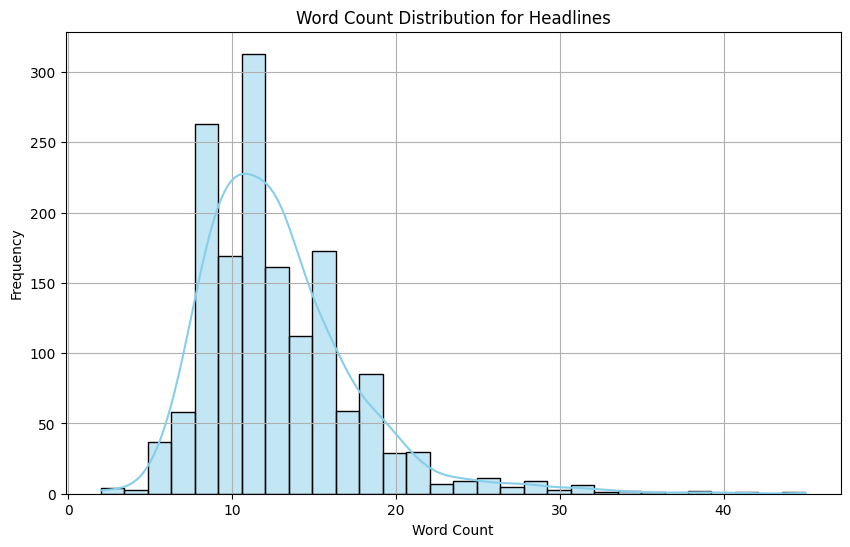

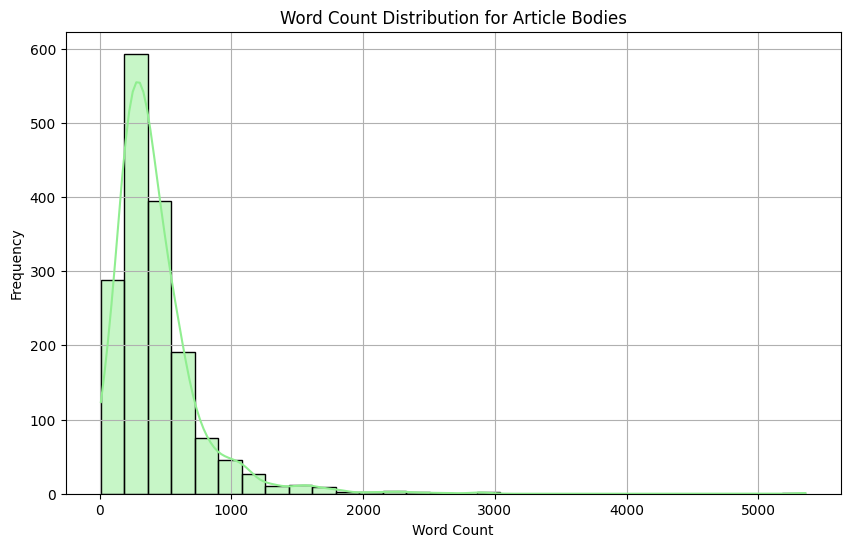

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize

# Tokenize text and calculate word counts for headlines and article bodies
headline_word_count = pd.Series(merged_data_cleaned['Headline'].unique()).apply(lambda x: len(word_tokenize(x)))
body_word_count = pd.Series(merged_data_cleaned['articleBody'].unique()).apply(lambda x: len(word_tokenize(x)))

# Analyze distribution of word counts for headlines and article bodies
print("Word Count Distribution for Headlines:")
print(headline_word_count.describe())

print("\nWord Count Distribution for Article Bodies:")
print(body_word_count.describe())

# Calculate summary statistics for word counts
headline_stats = {
    'Mean': headline_word_count.mean(),
    'Median': headline_word_count.median(),
    'Minimum': headline_word_count.min(),
    'Maximum': headline_word_count.max()
}

body_stats = {
    'Mean': body_word_count.mean(),
    'Median': body_word_count.median(),
    'Minimum': body_word_count.min(),
    'Maximum': body_word_count.max()
}

print("\nSummary Statistics for Headline Word Counts:")
for stat, value in headline_stats.items():
    print(f"{stat}: {value}")

print("\nSummary Statistics for Article Body Word Counts:")
for stat, value in body_stats.items():
    print(f"{stat}: {value}")

# Visualize distributions of word counts using histograms
plt.figure(figsize=(10, 6))
sns.histplot(data=headline_word_count, bins=30, color='skyblue', kde=True)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution for Headlines')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(data=body_word_count, bins=30, color='lightgreen', kde=True)
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Word Count Distribution for Article Bodies')
plt.grid(True)
plt.show()

**Headline Word Count**

Distribution Shape: The histogram and KDE plot illustrate a distribution of word counts for headlines that is right-skewed, indicating that most headlines tend to have fewer words, with a long tail towards higher word counts. This suggests that concise headlines are more common in the dataset.

Peak Word Count Range: The majority of headlines may have word counts ranging from approximately 5 to 20 words, as evidenced by the higher density of values in this range. This indicates that headlines in the dataset are typically short and to the point.

Rare High Word Counts: While most headlines have relatively low word counts, there are some headlines with word counts exceeding 30 words, although these instances are less common. This suggests the presence of longer, potentially more descriptive headlines in the dataset, although they are not as prevalent.

Mode of the Distribution: The mode of the distribution appears to be around 8 to 10 words, as indicated by the highest frequency of word counts in this range. This suggests that a significant portion of the headlines may fall within this word count range.

Spread of Word Counts: Similar to bodies, the spread of word counts for headlines varies, with some being very concise (2-5 words) while others are slightly longer (15+ words). This variability suggests a diverse range of headline lengths and styles within the dataset.

**Body Word Count**

**Distribution Shape**: The histogram and KDE plot illustrate a distribution of word counts for bodies that is likely right-skewed, similar to the distribution observed for headlines. This indicates that most bodies tend to have fewer words, with a long tail towards higher word counts.

**Peak Word Count Range**: The majority of bodies may have word counts ranging from approximately 100 to 500 words, as evidenced by the higher density of values in this range. This suggests that the bodies in the dataset are typically of moderate length.

**Rare High Word Counts**: While most bodies have relatively moderate word counts, there are some bodies with word counts exceeding 1000 words, although these instances are less common. This indicates the presence of longer, more detailed bodies within the dataset.

**Mode of the Distribution**: The mode of the distribution appears to be around 200 to 300 words, as indicated by the highest frequency of word counts in this range. This suggests that a significant portion of the bodies may fall within this word count range.

**Spread of Word Counts**: Similar to headlines, the spread of word counts for bodies varies, with some being very concise (50-100 words) while others are more extensive (500+ words). This variability suggests a diverse range of body lengths and styles within the dataset.

### Text Analysis

<ipython-input-59-649687263aa0>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_cleaned['body_tokens'] = merged_data_cleaned.apply(lambda row: get_tokenized_body(row['Body ID'], row['articleBody']), axis=1)
<ipython-input-59-649687263aa0>:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_cleaned['headline_tokens'] = merged_data_cleaned['Headline'].apply(get_tokenized_headline)
<ipython-input-59-649687263aa0>:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

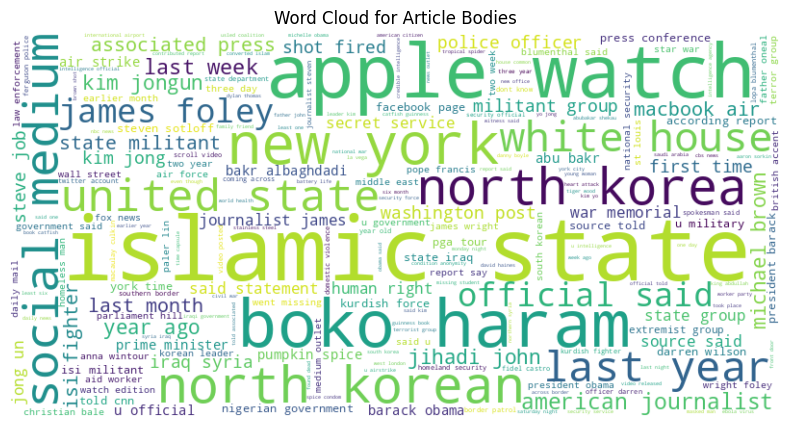

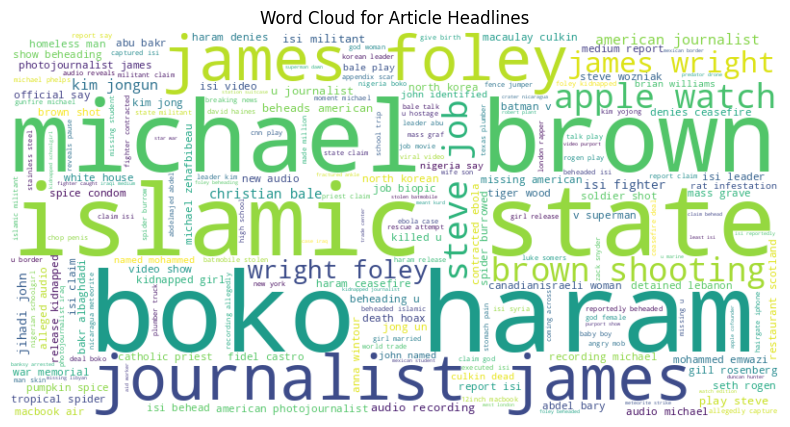

In [59]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import pandas as pd
import re
from spellchecker import SpellChecker

# Function to remove links from text
def remove_links(text):
    return re.sub(r'http\S+', '', text)

# Function to remove punctuation
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

# Function to perform spell correction
def correct_spelling(text):
    spell = SpellChecker()
    corrected_text = []
    for word in text:
        corrected_text.append(spell.correction(word))
    return corrected_text

# Tokenization, removing stop words, lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Create a dictionary to store tokenized bodies for efficient reuse
tokenized_bodies_dict = {}

def preprocess_text(text):
    text = remove_links(text)
    text = remove_punctuation(text)
    tokens = word_tokenize(text.lower())  # Tokenization and convert to lowercase
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum() and token not in stop_words]  # Remove stop words and lemmatization
    # tokens = correct_spelling(tokens) # Spell correction
    return tokens

def get_tokenized_body(body_id, body_text):
    if body_id in tokenized_bodies_dict:
        return tokenized_bodies_dict[body_id]
    else:
        tokenized_body = preprocess_text(body_text)
        tokenized_bodies_dict[body_id] = tokenized_body
        return tokenized_body

tokenized_headlines_dict = {}

def get_tokenized_headline(headline):
    if headline in tokenized_headlines_dict:
        return tokenized_headlines_dict[headline]
    else:
        tokenized_headline = preprocess_text(headline)
        tokenized_headlines_dict[headline] = tokenized_headline
        return tokenized_headline

merged_data_cleaned['body_tokens'] = merged_data_cleaned.apply(lambda row: get_tokenized_body(row['Body ID'], row['articleBody']), axis=1)
merged_data_cleaned['headline_tokens'] = merged_data_cleaned['Headline'].apply(get_tokenized_headline)

# Function to get the token count
def get_token_count(tokens):
    return len(tokens)

# Apply the token count function to each row
merged_data_cleaned['body_token_count'] = merged_data_cleaned['body_tokens'].apply(get_token_count)
merged_data_cleaned['headline_token_count'] = merged_data_cleaned['headline_tokens'].apply(get_token_count)


# Analyze most frequent words
def analyze_most_frequent_words(tokens):
    word_freq = Counter(tokens)
    most_common_words = word_freq.most_common(10)
    return most_common_words

# Get most frequent words for bodies
body_most_common_words = analyze_most_frequent_words([word for sublist in merged_data_cleaned['body_tokens'] for word in sublist])
headline_most_common_words = analyze_most_frequent_words([word for sublist in merged_data_cleaned['headline_tokens'] for word in sublist])


def visualize_word_cloud(tokens, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tokens))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Visualize word cloud for bodies
visualize_word_cloud([word for sublist in merged_data_cleaned['body_tokens'] for word in sublist], title="Word Cloud for Article Bodies")
visualize_word_cloud([word for sublist in merged_data_cleaned['headline_tokens'] for word in sublist], title="Word Cloud for Article Headlines")

In [60]:
headline_most_common_words

[('isi', 7212),
 ('u', 3542),
 ('report', 3459),
 ('say', 3351),
 ('claim', 3303),
 ('foley', 3135),
 ('video', 3043),
 ('james', 3036),
 ('michael', 2910),
 ('journalist', 2867)]

In [61]:
body_most_common_words

[('said', 125580),
 ('video', 41085),
 ('one', 41040),
 ('state', 40416),
 ('report', 38520),
 ('u', 37607),
 ('apple', 37443),
 ('would', 34274),
 ('time', 33903),
 ('people', 33831)]

## To Do

Stance vs. Length Analysis:

Compare the length of headlines/articles across different stance categories using boxplots or violin plots.
Analyze if there's any significant difference in length between stance categories.

Word Frequency by Stance:

Analyze the frequency of specific words or phrases within headlines/articles for each stance category.
Visualize word frequencies using bar charts or word clouds, separated by stance.

Temporal Analysis:

If the dataset contains timestamps, perform a temporal analysis to identify trends over time.
Analyze the distribution of articles over different time periods.
Identify any patterns or trends in stance categories over time.

Topical Analysis:

Explore the topics or themes covered in the headlines and article bodies using topic modeling techniques like Latent Dirichlet Allocation (LDA).
Identify clusters of articles with similar topics/themes